INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Starting training with PyTorch Lightning...


Epoch 1/10:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch 2/10:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch 3/10:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch 4/10:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch 5/10:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch 6/10:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch 7/10:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch 8/10:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch 9/10:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch 10/10:   0%|          | 0/782 [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


Plotting training curves...


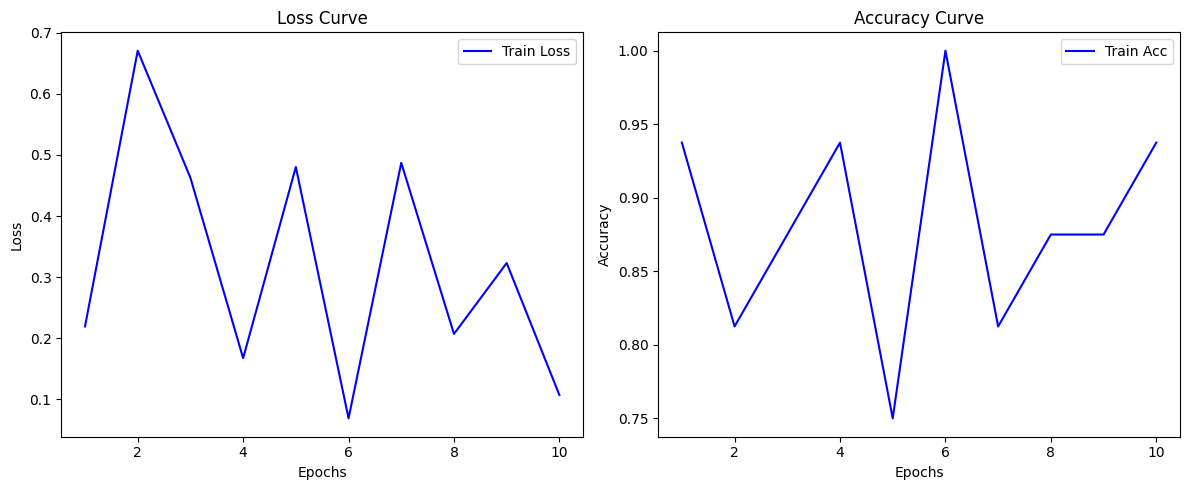

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │    0.9064000248908997     │
│         val_loss          │    0.3578404188156128     │
└───────────────────────────┴───────────────────────────┘

Generating prediction visualization...


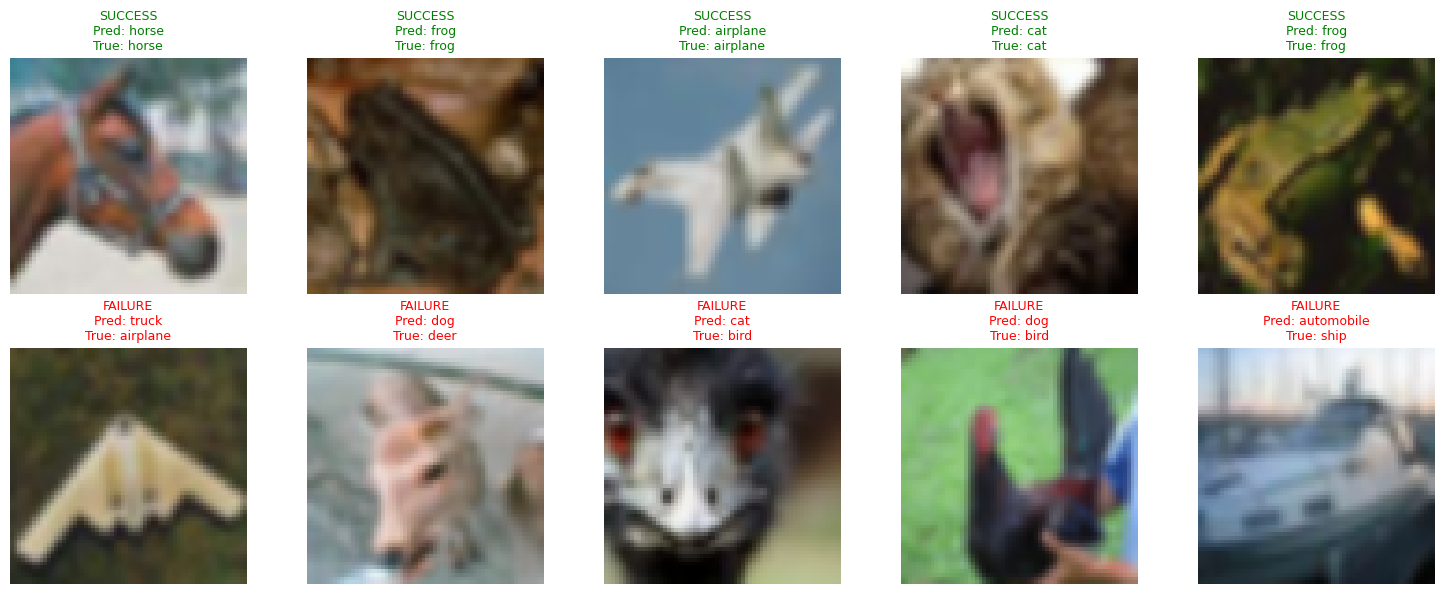

In [19]:
# In Google Colab, uncomment and run the following line first:
# !pip install pytorch-lightning

import torch

import torch.nn as nn
import torch.optim as optim
import torchvision
from torch.utils.data import DataLoader
import pytorch_lightning as pl
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import numpy as np
import random

# Device is handled automatically by PL, but for manual plotting we might need it
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ------------------------
# 1. Lightning Module
# ------------------------
class FusionModel(pl.LightningModule):
    def __init__(self, num_classes=10, lr=1e-4):
        super().__init__()
        self.save_hyperparameters()

        # Pretrained CNN backbone
        cnn = models.resnet18(weights="DEFAULT")
        self.cnn = nn.Sequential(*list(cnn.children())[:-2])  # remove FC + avgpool
        self.cnn_out_channels = 512

        # Project CNN output to transformer embedding
        self.conv1x1 = nn.Conv2d(self.cnn_out_channels, 256, kernel_size=1)

        # Transformer encoder
        encoder_layer = nn.TransformerEncoderLayer(d_model=256, nhead=4, batch_first=True)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=2)

        # Classification head
        self.classifier = nn.Linear(256, num_classes)

        # Loss
        self.criterion = nn.CrossEntropyLoss()

        # Metrics storage
        self.validation_step_outputs = []

    def forward(self, x):
        x = self.cnn(x)                # [B, C, H, W]
        x = self.conv1x1(x)            # [B, 256, H, W]
        B, C, H, W = x.shape
        x = x.flatten(2).permute(0, 2, 1)  # [B, H*W, C]
        x = self.transformer(x)        # [B, H*W, C]
        x = x.mean(dim=1)              # global average pooling
        out = self.classifier(x)       # [B, num_classes]
        return out

    def training_step(self, batch, batch_idx):
        images, labels = batch
        outputs = self(images)
        loss = self.criterion(outputs, labels)

        # Logging
        acc = (outputs.argmax(dim=1) == labels).float().mean()
        self.log("train_loss", loss, prog_bar=True)
        self.log("train_acc", acc, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        images, labels = batch
        outputs = self(images)
        loss = self.criterion(outputs, labels)
        preds = outputs.argmax(dim=1)
        acc = (preds == labels).float().mean()

        self.log("val_loss", loss, prog_bar=True)
        self.log("val_acc", acc, prog_bar=True)
        self.validation_step_outputs.append({"val_loss": loss, "val_acc": acc})
        return loss

    def configure_optimizers(self):
        return optim.AdamW(self.parameters(), lr=self.hparams.lr)

# ------------------------
# 2. Data Logic
# ------------------------
# Transforms
transform_train = transforms.Compose([
    transforms.Resize((64,64)),  # upscale for transformer
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
])

transform_test = transforms.Compose([
    transforms.Resize((64,64)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
])

def get_dataloaders(batch_size=64):
    train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
    test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
    return train_loader, test_loader, train_dataset.classes

# ------------------------
# 3. Visualization & Callbacks
# ------------------------
class LiteProgressBar(pl.Callback):
    def on_train_epoch_start(self, trainer, pl_module):
        # Mimic Main.py: "Epoch X/Y"
        desc = f"Epoch {trainer.current_epoch+1}/{trainer.max_epochs}"
        self.pbar = tqdm(total=trainer.num_training_batches, desc=desc, leave=True)
        # Initialize running metrics for this epoch
        self.running_loss = 0.0
        self.running_correct = 0
        self.running_total = 0

    def on_train_batch_end(self, trainer, pl_module, outputs, batch, batch_idx):
        # Retrieve latest logged metrics
        loss_val = trainer.callback_metrics.get("train_loss", 0.0).item()
        acc_val = trainer.callback_metrics.get("train_acc", 0.0).item()

        # Approximate running count recovery
        # (Since we don't have raw preds/labels here easily without modifying return,
        #  we reuse the batch average logged by PL. This is mathematically correct if batch sizes are constant)
        images, labels = batch
        batch_size = labels.size(0)

        self.running_loss += loss_val * batch_size
        self.running_correct += int(acc_val * batch_size)
        self.running_total += batch_size

        avg_loss = self.running_loss / self.running_total
        avg_acc = self.running_correct / self.running_total

        # Format like Main.py: Loss: x.xxxx, Acc: xx.xx%
        self.pbar.set_postfix({"Loss": f"{avg_loss:.4f}", "Acc": f"{avg_acc*100:.2f}%"})
        self.pbar.update(1)

    def on_train_epoch_end(self, trainer, pl_module):
        self.pbar.close()

class MetricTracker(pl.Callback):
    def __init__(self):
        self.collection = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}

    def on_train_epoch_end(self, trainer, pl_module):
        # Retrieve metrics from trainer.callback_metrics
        # Note: these are logged in training_step/validation_step
        metrics = trainer.callback_metrics
        if "train_loss" in metrics:
            self.collection["train_loss"].append(metrics["train_loss"].item())
        if "train_acc" in metrics:
            self.collection["train_acc"].append(metrics["train_acc"].item())

    def on_validation_epoch_end(self, trainer, pl_module):
        metrics = trainer.callback_metrics
        if "val_loss" in metrics:
            self.collection["val_loss"].append(metrics["val_loss"].item())
        if "val_acc" in metrics:
            self.collection["val_acc"].append(metrics["val_acc"].item())

def plot_metrics(history):
    epochs = range(1, len(history["train_loss"]) + 1)

    plt.figure(figsize=(12, 5))

    # Loss Plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history["train_loss"], 'b-', label='Train Loss')
    # Val loss might be shorter if sanity check runs, or aligned.
    # Usually PL runs val at end of epoch.
    if len(history["val_loss"]) == len(epochs):
        plt.plot(epochs, history["val_loss"], 'r-', label='Val Loss')
    plt.title("Loss Curve")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()

    # Accuracy Plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history["train_acc"], 'b-', label='Train Acc')
    if len(history["val_acc"]) == len(epochs):
        plt.plot(epochs, history["val_acc"], 'r-', label='Val Acc')
    plt.title("Accuracy Curve")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()

    plt.tight_layout()
    plt.show()

def visualize_results(model, loader, classes, num_samples=5):
    """
    Shows a grid of Successful predictions and Failed predictions.
    """
    model.eval()
    model.to(device)

    success_cases = []
    failure_cases = []

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = outputs.max(1)

            # Identify successes and failures
            correct_mask = (preds == labels)

            # Store some samples (image, pred, true)
            for i in range(len(labels)):
                img_data = (images[i].cpu(), preds[i].item(), labels[i].item())
                if correct_mask[i]:
                    success_cases.append(img_data)
                else:
                    failure_cases.append(img_data)

            # Stop if we collected enough of both
            if len(success_cases) >= num_samples and len(failure_cases) >= num_samples:
                break

    # Shuffle to get random ones if we collected many
    random.shuffle(success_cases)
    random.shuffle(failure_cases)

    # Plot
    fig, axes = plt.subplots(2, num_samples, figsize=(15, 6))

    # helper to denormalize
    def denorm(tensor):
        img = tensor.permute(1,2,0).numpy()
        return (img * 0.5 + 0.5)

    # Plot Successes
    for i in range(num_samples):
        if i < len(success_cases):
            img, pred, true_lbl = success_cases[i]
            ax = axes[0, i]
            ax.imshow(denorm(img))
            ax.set_title(f"SUCCESS\nPred: {classes[pred]}\nTrue: {classes[true_lbl]}", color="green", fontsize=9)
            ax.axis('off')

    # Plot Failures
    for i in range(num_samples):
        if i < len(failure_cases):
            img, pred, true_lbl = failure_cases[i]
            ax = axes[1, i]
            ax.imshow(denorm(img))
            ax.set_title(f"FAILURE\nPred: {classes[pred]}\nTrue: {classes[true_lbl]}", color="red", fontsize=9)
            ax.axis('off')

    plt.tight_layout()
    plt.show()

# ------------------------
# 4. Main Execution
# ------------------------
if __name__ == "__main__":
    train_loader, test_loader, class_names = get_dataloaders()

    # Initialize model
    model = FusionModel(num_classes=10)

    # Custom Callbacks
    metric_tracker = MetricTracker()
    lite_pbar = LiteProgressBar()

    # Trainer
    trainer = pl.Trainer(
        max_epochs=10,
        accelerator="auto",
        devices=1,
        enable_progress_bar=False,  # Disable default bar
        callbacks=[lite_pbar, metric_tracker], # Use our custom bar
        enable_checkpointing=False,
        logger=False,
        enable_model_summary=False
    )

    # Train
    print("Starting training with PyTorch Lightning...")
    trainer.fit(model, train_loader, test_loader)

    # Plot Metrics
    print("Plotting training curves...")
    plot_metrics(metric_tracker.collection)

    # Test/Validate final metrics
    trainer.validate(model, test_loader)

    # Visualization
    print("Generating prediction visualization...")
    visualize_results(model, test_loader, class_names, num_samples=5)
